In [1]:
from matplotlib import pyplot as plt

In [2]:
from pyveg.src.data_analysis_utils import *
%matplotlib inline


In [3]:

def resample_time_series(df, col_name="offset50",period = "D"):
    """
    Resample and interpolate a time series dataframe so we have one row
    per day (useful for FFT)

    Parameters
    ----------
    df: DataFrame with date as index
    col_name: string, identifying the column we will pull out

    Returns
    -------
    new_series: pandas Series with datetime index, and one column, one row per day
    """
    series = df[col_name]
    # just in case the index isn't already datetime type
    series.index = pd.to_datetime(series.index)

    # resample to get one row per day
    rseries = series.resample(period).mean()
    
    new_series = rseries.interpolate()

    return new_series

In [4]:
def read_file_create_ts(input_dir):

    output_dir = os.path.join(input_dir, 'analysis')

    # check file exists
    json_summary_path = os.path.join(input_dir, 'results_summary.json')
    dfs = variable_read_json_to_dataframe(json_summary_path)
    time_series_dfs = make_time_series(dfs)
    
    offsets = resample_time_series(time_series_dfs['COPERNICUS/S2'], col_name="offset50",period="M")
    precipitation = resample_time_series(time_series_dfs['ECMWF/ERA5/MONTHLY'], col_name="total_precipitation",period="M")

    precipitation = precipitation[precipitation.index.isin(offsets.index)]
    return offsets, precipitation


In [5]:
input_dir_spots = '/Users/crangelsmith/PycharmProjects/monitoring-ecosystem-resilience/output/Copernicus_Spots_2016_2020/__2020-03-09_16-46-33/'
input_dir_laberynths = '/Users/crangelsmith/PycharmProjects/monitoring-ecosystem-resilience/output/labyrinths/'
input_dir_gaps = '/Users/crangelsmith/PycharmProjects/monitoring-ecosystem-resilience/output/gaps/'


In [6]:
offsets, precipitation = read_file_create_ts(input_dir_spots)

print (precipitation.shape)

(48,)


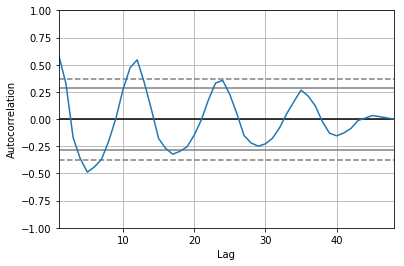

In [7]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(precipitation)
plt.show()

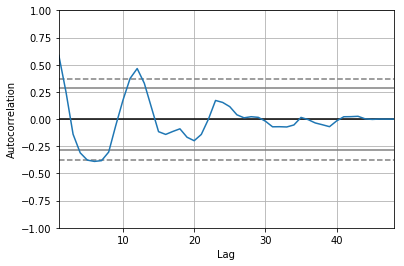

In [8]:

from pandas.plotting import autocorrelation_plot
autocorrelation_plot(offsets)
plt.show()


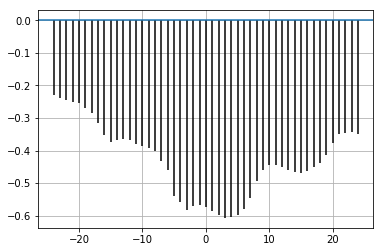

In [9]:

fig, ax1 = plt.subplots(1, 1, sharex=True)

ax1.xcorr(precipitation, offsets, usevlines=True, maxlags=24, normed=True, lw=1.5)
ax1.grid(True)


plt.show()

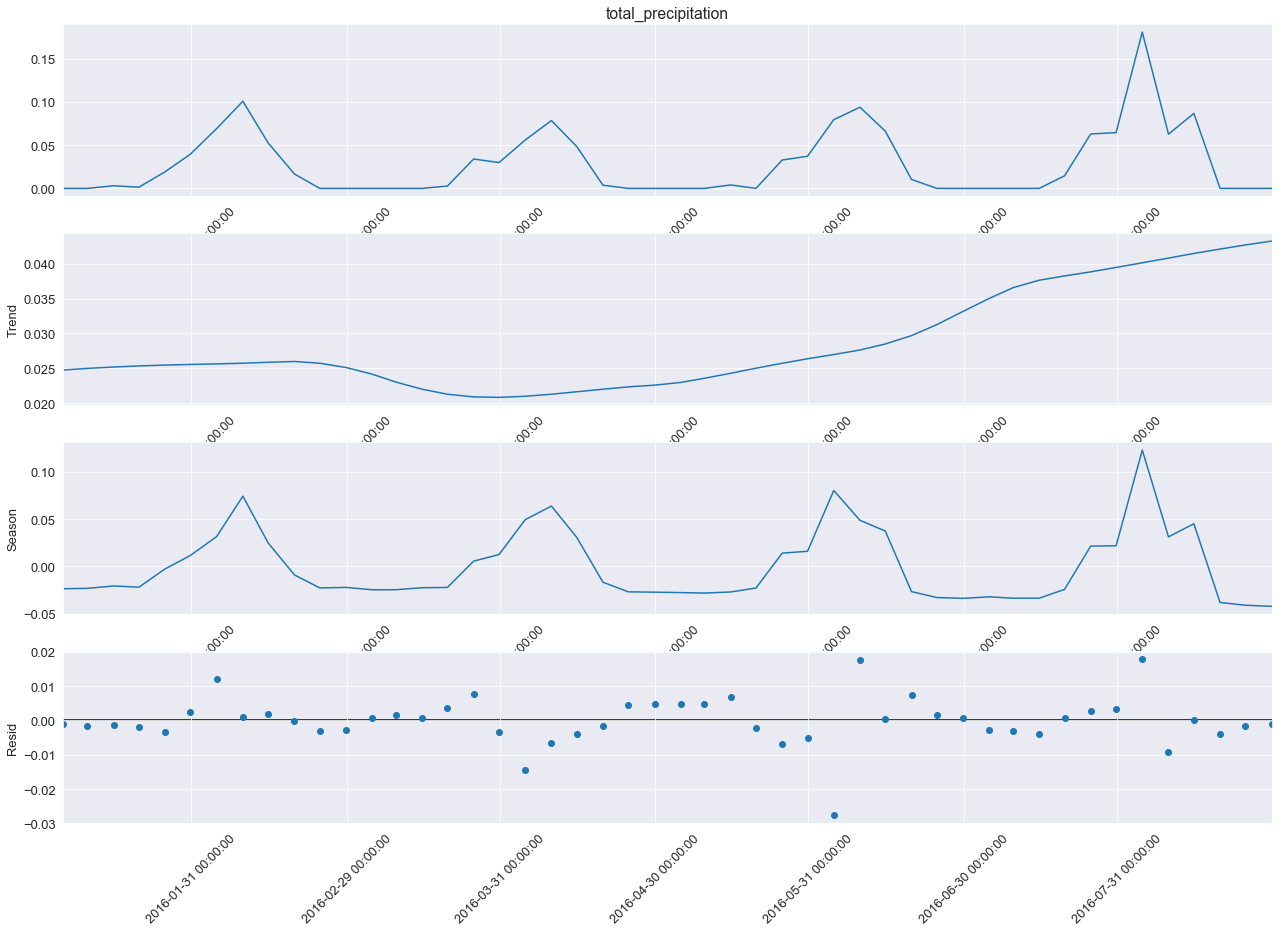

In [12]:
from pandas.plotting import register_matplotlib_converters
import seaborn as sns

register_matplotlib_converters()
sns.set_style('darkgrid')
plt.rc('figure',figsize=(18,12))
plt.rc('font',size=13)

from statsmodels.tsa.seasonal import STL

stl = STL(precipitation, period=12)
res = stl.fit()
fig = res.plot()

ax_list = fig.axes

for ax in ax_list:
    ax.set_xticklabels(precipitation.index, rotation = 45, va="center", position=(0,-0.28))

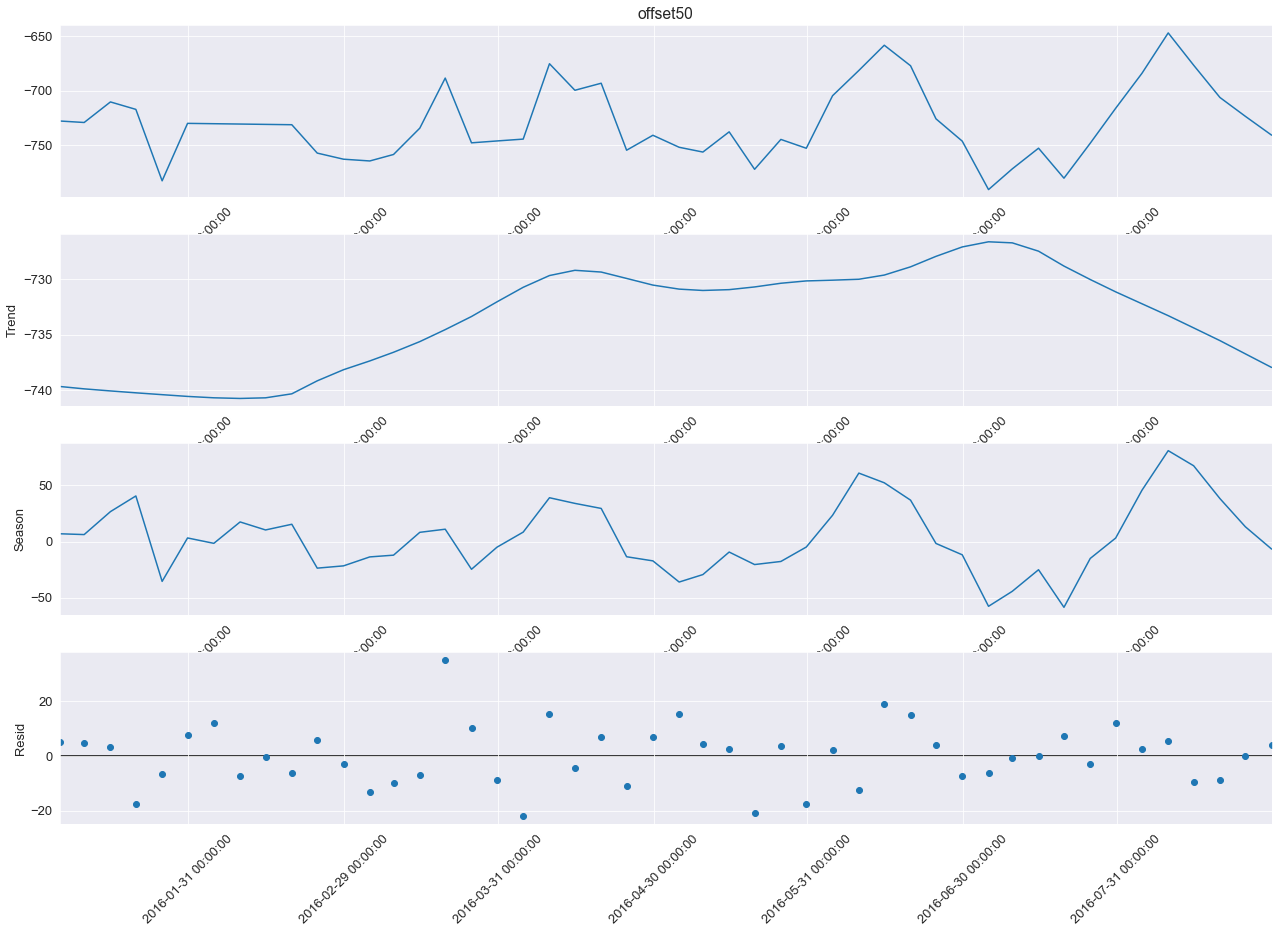

In [11]:
from pandas.plotting import register_matplotlib_converters
import seaborn as sns

register_matplotlib_converters()
sns.set_style('darkgrid')
plt.rc('figure',figsize=(18,12))
plt.rc('font',size=13)

from statsmodels.tsa.seasonal import STL

stl = STL(offsets, period=12)

res = stl.fit()
fig = res.plot()

ax_list = fig.axes

for ax in ax_list:
    ax.set_xticklabels(offsets.index, rotation = 45, va="center", position=(0,-0.28))

In [12]:
import statsmodels.api as sm

#df1 = pd.DataFrame(precipitation.diff(12))
#df2 = pd.DataFrame(offsets.diff(12))

df1 = pd.DataFrame(precipitation)
df2 = pd.DataFrame(offsets)



endog = df1.join(df2, how='outer')
endog.dropna(inplace = True)

endog['total_precipitation'] = (endog['total_precipitation'] - endog['total_precipitation'].mean()) / endog['total_precipitation'].std()
endog['offset50'] = (endog['offset50'] - endog['offset50'].mean()) / endog['offset50'].std()
# Get the endogenous data

# Create the model
mod = sm.tsa.DynamicFactor(endog, k_factors=1, factor_order=1, error_order=1)
initial_res = mod.fit(method='powell', disp=False)
res = mod.fit(initial_res.params, disp=False)

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [13]:
print(res.summary(separate_params=False))


                                    Statespace Model Results                                   
Dep. Variable:     ['total_precipitation', 'offset50']   No. Observations:                   48
Model:               DynamicFactor(factors=1, order=1)   Log Likelihood                -112.112
                                        + AR(1) errors   AIC                            238.223
Date:                                 Fri, 27 Mar 2020   BIC                            251.322
Time:                                         09:59:16   HQIC                           243.173
Sample:                                     01-31-2016                                         
                                          - 12-31-2019                                         
Covariance Type:                                   opg                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
-------------------

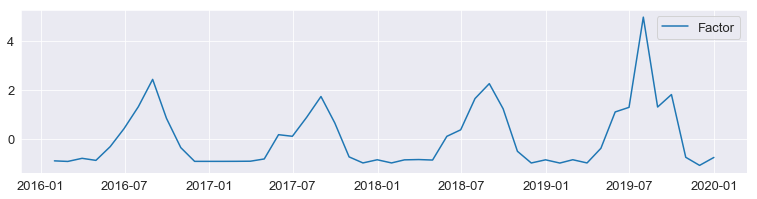

In [14]:
fig, ax = plt.subplots(figsize=(13,3))

# Plot the factor
dates = endog.index._mpl_repr()
ax.plot(dates, res.factors.filtered[0], label='Factor')
ax.legend()

In [15]:

df1 = pd.DataFrame(precipitation.diff(12))
df2 = pd.DataFrame(offsets.diff(12))

endog = df1.join(df2, how='outer')
endog.dropna(inplace = True)

endog['total_precipitation'] = (endog['total_precipitation'] - endog['total_precipitation'].mean()) / endog['total_precipitation'].std()
endog['offset50'] = (endog['offset50'] - endog['offset50'].mean()) / endog['offset50'].std()
# Get the endogenous data

# Create the model
mod = sm.tsa.DynamicFactor(endog, k_factors=1, factor_order=1, error_order=1)
initial_res = mod.fit(method='powell', disp=False)
res = mod.fit(initial_res.params, disp=False)
print(res.summary(separate_params=False))


                                    Statespace Model Results                                   
Dep. Variable:     ['total_precipitation', 'offset50']   No. Observations:                   36
Model:               DynamicFactor(factors=1, order=1)   Log Likelihood                 -97.588
                                        + AR(1) errors   AIC                            209.177
Date:                                 Fri, 27 Mar 2020   BIC                            220.261
Time:                                         09:59:16   HQIC                           213.046
Sample:                                     01-31-2017                                         
                                          - 12-31-2019                                         
Covariance Type:                                   opg                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
-------------------

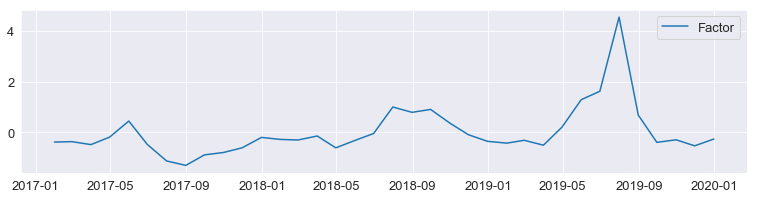

In [16]:
fig, ax = plt.subplots(figsize=(13,3))

# Plot the factor
dates = endog.index._mpl_repr()
ax.plot(dates, res.factors.filtered[0], label='Factor')
ax.legend()